Null values per column:
 ROPOLine                          0
Task Order                        0
Condom Adjusted Task Order        0
Country                           0
RO Number                         0
                              ...  
Pick Up                       21150
Deliver                       15343
Quality Assurance             38560
Reason Code                   14282
Reason Code Duration          21548
Length: 104, dtype: int64
Shape of X_no_outliers: (17941, 8)
Shape of y1_no_outliers: (17941,)


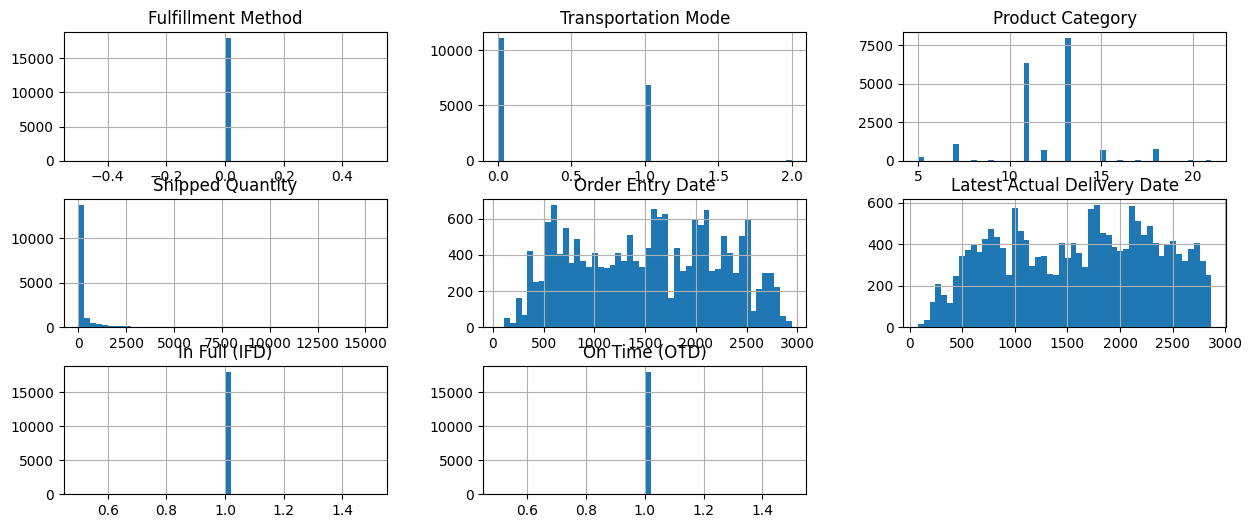


ANOVA test for Fulfillment Method and Delivery Time: p-value = 4.141711438530749e-08
ANOVA test for Product Category and Delivery Time: p-value = 0.0
ANOVA test for Transportation Mode and Delivery Time: p-value = 0.0

Chi-Square test for OTIF Status and Fulfillment Method: p-value = 1.274195114665213e-06
Chi-Square test for OTIF Status and Product Category: p-value = 2.464507533047977e-175
Chi-Square test for OTIF Status and Transportation Mode: p-value = 3.088266474730464e-10

T-test for Shipped Quantity and OTIF Status: t-stat = 9.7630, p-value = 0.0000


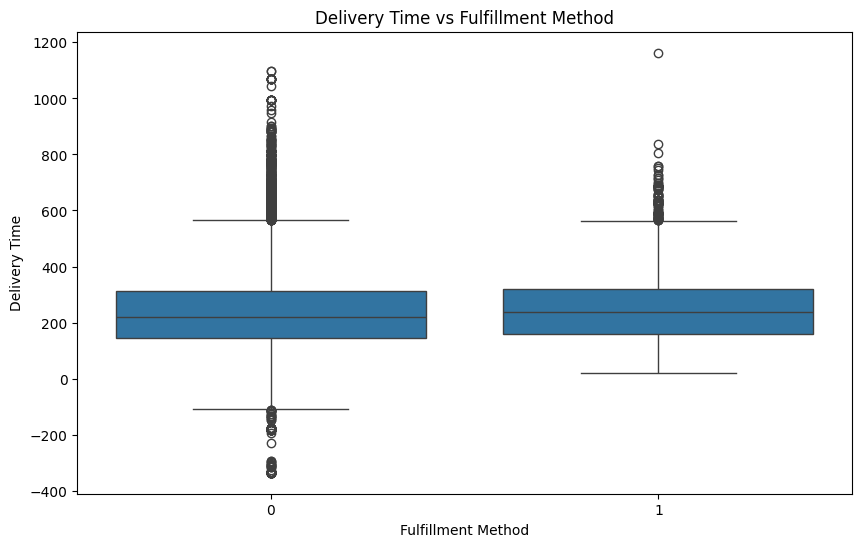

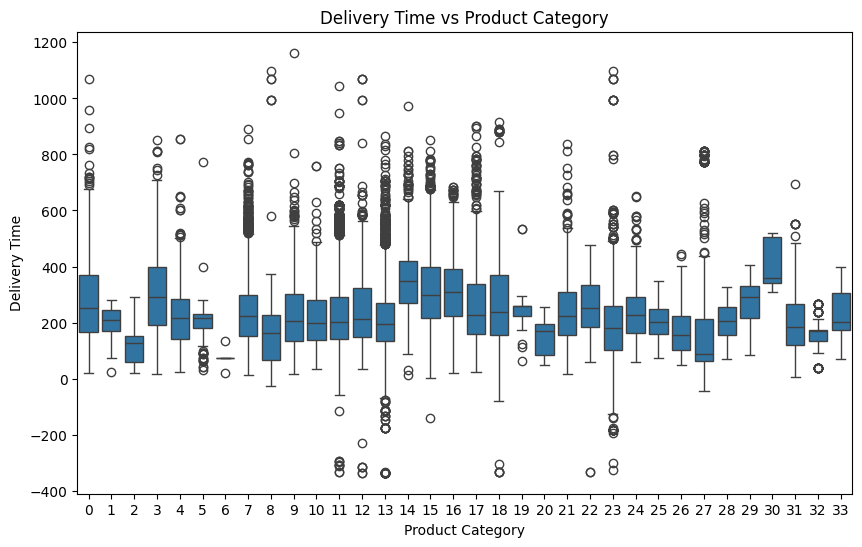

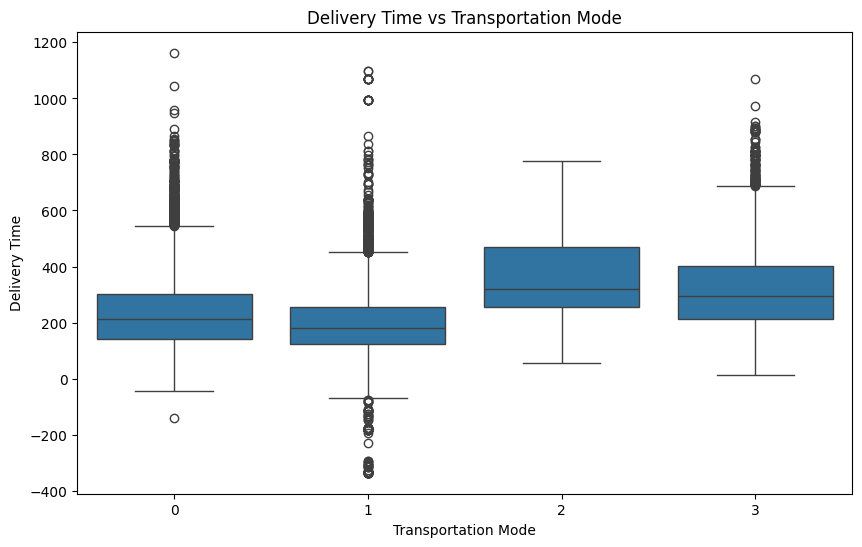

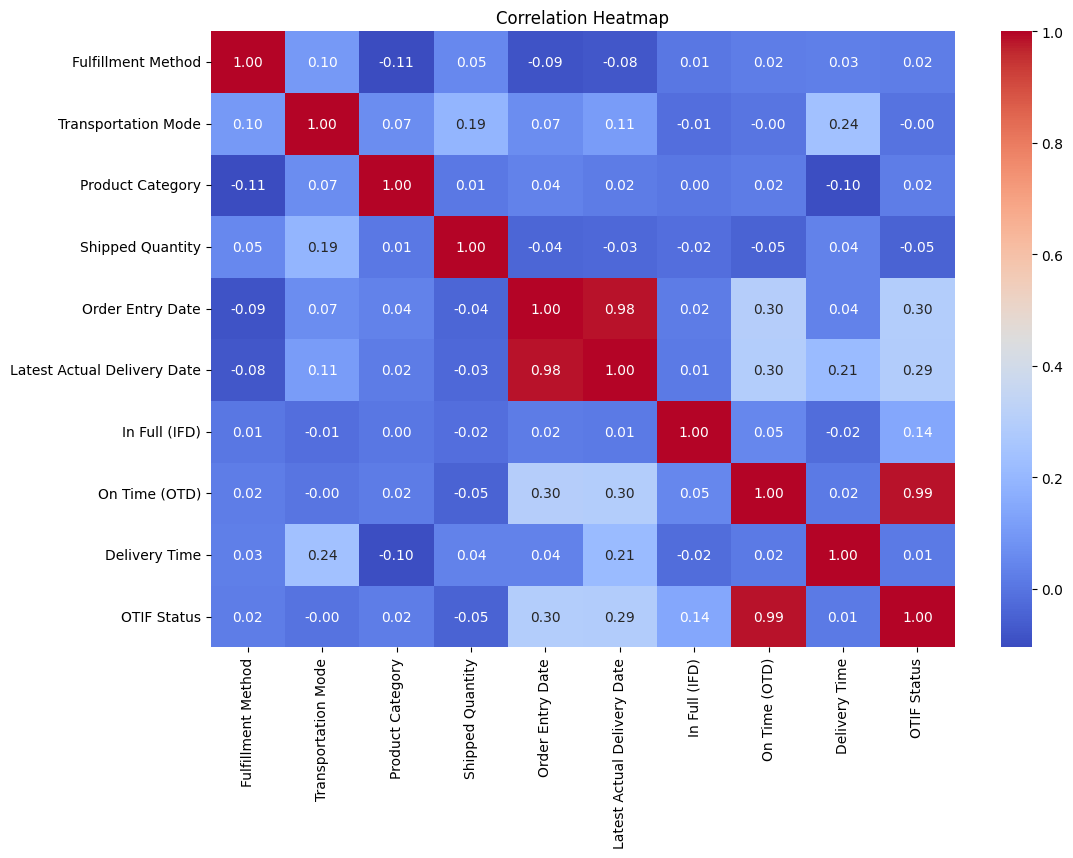


Training models for 'Delivery Time':
K-Neighbors Regressor Performance:
Train - MAE: 14.7528, RMSE: 32.1964, R2: 0.9194
Test - MAE: 19.7180, RMSE: 41.7002, R2: 0.8558
Random Forest Regressor Performance:
Train - MAE: 0.9013, RMSE: 3.1223, R2: 0.9992
Test - MAE: 2.1696, RMSE: 6.4226, R2: 0.9966
Adaboost Regressor Performance:
Train - MAE: 73.4506, RMSE: 89.9935, R2: 0.3705
Test - MAE: 73.3228, RMSE: 89.3063, R2: 0.3387
Gradient Boosting Regressor Performance:
Train - MAE: 28.4523, RMSE: 37.4874, R2: 0.8908
Test - MAE: 28.6707, RMSE: 37.7022, R2: 0.8821
Fitting 3 folds for each of 50 candidates, totalling 150 fits
Fitting 3 folds for each of 50 candidates, totalling 150 fits
Best Parameters for Models:
Random Forest: {'n_estimators': 200, 'min_samples_split': 2, 'max_features': 'log2', 'max_depth': None}
Gradient Boosting: {'n_estimators': 500, 'max_depth': 5, 'loss': 'huber', 'learning_rate': 0.2}

Tuned Model Performance for 'Delivery Time':
=====Tuned Random Forest Performance:
Train

In [ ]:
# Import Libraries
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.impute import SimpleImputer
import warnings
import matplotlib.pyplot as plt

warnings.filterwarnings("ignore")

df = pd.read_csv(r'C:\Users\lavan\OneDrive\Documents\DSCI5260\final project dataset.csv', low_memory=False)

print("Null values per column:\n", df.isnull().sum())

df['Order Entry Date'] = pd.to_datetime(df['Order Entry Date'], errors='coerce')
df['Agreed Delivery Date'] = pd.to_datetime(df['Agreed Delivery Date'], errors='coerce')

if 'Delivery Time' not in df.columns:
    df['Delivery Time'] = (df['Agreed Delivery Date'] - df['Order Entry Date']).dt.days

if 'OTIF Status' not in df.columns:
    df['OTIF Status'] = ((df['In Full (IFD)'] == 'Y') & (df['On Time (OTD)'] == 'Y')).astype(int)

columns_of_interest = ['Fulfillment Method', 'Transportation Mode', 'Product Category', 
                       'Shipped Quantity', 'Order Entry Date', 'Latest Actual Delivery Date', 
                       'In Full (IFD)', 'On Time (OTD)','Delivery Time','OTIF Status']

df_selected = df[columns_of_interest]

df_selected['Order Entry Date'] = pd.to_datetime(df_selected['Order Entry Date'], errors='coerce')
df_selected['Latest Actual Delivery Date'] = pd.to_datetime(df_selected['Latest Actual Delivery Date'], errors='coerce')


df_selected['Delivery Time'] = (df_selected['Latest Actual Delivery Date'] - df_selected['Order Entry Date']).dt.days
df_selected['OTIF Status'] = ((df_selected['In Full (IFD)'] == 'Y') & (df_selected['On Time (OTD)'] == 'Y')).astype(int)

categorical_features = df_selected.select_dtypes(include="object").columns
for feature in categorical_features:
    df_selected[feature] = LabelEncoder().fit_transform(df_selected[feature].astype(str))

# Convert 'Order Entry Date' and 'Latest Actual Delivery Date' to numeric format
df_selected['Order Entry Date'] = (df_selected['Order Entry Date'] - df_selected['Order Entry Date'].min()).dt.days
df_selected['Latest Actual Delivery Date'] = (df_selected['Latest Actual Delivery Date'] - df_selected['Latest Actual Delivery Date'].min()).dt.days

# Separate independent (X) and dependent variables (y1, y2)
X = df_selected.drop(['Delivery Time', 'OTIF Status'], axis=1)
y1 = df_selected['Delivery Time']
y2 = df_selected['OTIF Status']

# Handle missing values
X.fillna(X.median(), inplace=True)
y1.fillna(y1.mean(), inplace=True)

#  Outlier Detection and Removal (IQR method)
Q1 = X.quantile(0.25)
Q3 = X.quantile(0.75)
IQR = Q3 - Q1
outlier_condition = (X >= (Q1 - 1.5 * IQR)) & (X <= (Q3 + 1.5 * IQR))
X_no_outliers = X[outlier_condition.all(axis=1)]
y1_no_outliers = y1[outlier_condition.all(axis=1)]
print(f"Shape of X_no_outliers: {X_no_outliers.shape}")
print(f"Shape of y1_no_outliers: {y1_no_outliers.shape}")

fig, ax = plt.subplots(1, 2, figsize=(15, 6))
X.hist(bins=50, ax=ax[0])
ax[0].set_title("Before Removing Outliers")

X_no_outliers.hist(bins=50, ax=ax[1])
ax[1].set_title("After Removing Outliers")

plt.show()

from scipy import stats
import seaborn as sns

# Hypothesis testing for 'Delivery Time' and categorical features

anova_result_fulfillment_method = stats.f_oneway(*[df_selected['Delivery Time'][df_selected['Fulfillment Method'] == i] for i in df_selected['Fulfillment Method'].unique()])
print(f"\nANOVA test for Fulfillment Method and Delivery Time: p-value = {anova_result_fulfillment_method.pvalue}")


anova_result_product_category = stats.f_oneway(*[df_selected['Delivery Time'][df_selected['Product Category'] == i] for i in df_selected['Product Category'].unique()])
print(f"ANOVA test for Product Category and Delivery Time: p-value = {anova_result_product_category.pvalue}")

anova_result_transport_mode = stats.f_oneway(*[df_selected['Delivery Time'][df_selected['Transportation Mode'] == i] for i in df_selected['Transportation Mode'].unique()])
print(f"ANOVA test for Transportation Mode and Delivery Time: p-value = {anova_result_transport_mode.pvalue}")

#  Hypothesis testing for 'OTIF Status' and categorical features Perform Chi-Square test 


contingency_fulfillment_method = pd.crosstab(df_selected['OTIF Status'], df_selected['Fulfillment Method'])
chi2_fulfillment_method, p_fulfillment_method, _, _ = stats.chi2_contingency(contingency_fulfillment_method)
print(f"\nChi-Square test for OTIF Status and Fulfillment Method: p-value = {p_fulfillment_method}")


contingency_product_category = pd.crosstab(df_selected['OTIF Status'], df_selected['Product Category'])
chi2_product_category, p_product_category, _, _ = stats.chi2_contingency(contingency_product_category)
print(f"Chi-Square test for OTIF Status and Product Category: p-value = {p_product_category}")


contingency_transport_mode = pd.crosstab(df_selected['OTIF Status'], df_selected['Transportation Mode'])
chi2_transport_mode, p_transport_mode, _, _ = stats.chi2_contingency(contingency_transport_mode)
print(f"Chi-Square test for OTIF Status and Transportation Mode: p-value = {p_transport_mode}")


t_stat, p_value = stats.ttest_ind(df_selected['Shipped Quantity'][df_selected['OTIF Status'] == 0], 
                                  df_selected['Shipped Quantity'][df_selected['OTIF Status'] == 1])
print(f"\nT-test for Shipped Quantity and OTIF Status: t-stat = {t_stat:.4f}, p-value = {p_value:.4f}")

#  Visualizing results of hypothesis tests

plt.figure(figsize=(10, 6))
sns.boxplot(x='Fulfillment Method', y='Delivery Time', data=df_selected)
plt.title('Delivery Time vs Fulfillment Method')
plt.show()

plt.figure(figsize=(10, 6))
sns.boxplot(x='Product Category', y='Delivery Time', data=df_selected)
plt.title('Delivery Time vs Product Category')
plt.show()

plt.figure(figsize=(10, 6))
sns.boxplot(x='Transportation Mode', y='Delivery Time', data=df_selected)
plt.title('Delivery Time vs Transportation Mode')
plt.show()

# Heatmap of Correlation Matrix for numerical features
plt.figure(figsize=(12, 8))
sns.heatmap(df_selected.corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title("Correlation Heatmap")
plt.show()



# Split dataset into training and testing sets (using data without outliers)
X_train, X_test, y1_train, y1_test = train_test_split(X_no_outliers, y1_no_outliers, test_size=0.2, random_state=42)
_, _, y2_train, y2_test = train_test_split(X_no_outliers, y2.loc[y1_no_outliers.index], test_size=0.2, random_state=42)
cat_features = X.select_dtypes(include="object").columns

preprocessor = ColumnTransformer(
    transformers=[ 
        ('num', SimpleImputer(strategy='median'), X_no_outliers.select_dtypes(exclude="object").columns),
        ('cat', SimpleImputer(strategy='most_frequent'), cat_features)
    ],
    remainder='passthrough'
)

X_train = preprocessor.fit_transform(X_train)
X_test = preprocessor.transform(X_test)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
# Evaluate Model Function
def evaluate_model(true, predicted):
    mae = mean_absolute_error(true, predicted)
    mse = mean_squared_error(true, predicted)
    rmse = np.sqrt(mse)
    r2 = r2_score(true, predicted)
    return mae, rmse, r2

print("\nTraining models for 'Delivery Time':")
models = {
    "K-Neighbors Regressor": KNeighborsRegressor(),
    "Random Forest Regressor": RandomForestRegressor(),
    "Adaboost Regressor": AdaBoostRegressor(),
    "Gradient Boosting Regressor": GradientBoostingRegressor()
}

for name, model in models.items():
    model.fit(X_train, y1_train)
    y1_train_pred = model.predict(X_train)
    y1_test_pred = model.predict(X_test)
    train_mae, train_rmse, train_r2 = evaluate_model(y1_train, y1_train_pred)
    test_mae, test_rmse, test_r2 = evaluate_model(y1_test, y1_test_pred)
    print(f"{name} Performance:")
    print(f"Train - MAE: {train_mae:.4f}, RMSE: {train_rmse:.4f}, R2: {train_r2:.4f}")
    print(f"Test - MAE: {test_mae:.4f}, RMSE: {test_rmse:.4f}, R2: {test_r2:.4f}")
    print("=" * 50)

# Step 3: Hyperparameter Tuning with RandomizedSearchCV
rf_params = {
    "n_estimators": [100, 200, 500],
    "max_depth": [5, 10, 15, None],
    "min_samples_split": [2, 5, 10],
    "max_features": ["auto", "sqrt", "log2"]
}

gbr_params = {
    "n_estimators": [100, 200, 500],
    "max_depth": [3, 5, 10],
    "learning_rate": [0.01, 0.1, 0.2],
    "loss": ["squared_error", "huber"]
}

randomcv_models = [
    ("Random Forest", RandomForestRegressor(), rf_params),
    ("Gradient Boosting", GradientBoostingRegressor(), gbr_params)
]

best_params = {}
for name, model, params in randomcv_models:
    random_search = RandomizedSearchCV(model, params, n_iter=50, cv=3, n_jobs=-1, verbose=2, random_state=42)
    random_search.fit(X_train, y1_train)
    best_params[name] = random_search.best_params_

print("Best Parameters for Models:")
for model_name, params in best_params.items():
    print(f"{model_name}: {params}")

# Retrain models with the best parameters
tuned_models = {
    "Random Forest": RandomForestRegressor(**best_params["Random Forest"]),
    "Gradient Boosting": GradientBoostingRegressor(**best_params["Gradient Boosting"])
}

print("\nTuned Model Performance for 'Delivery Time':")
for name, model in tuned_models.items():
    model.fit(X_train, y1_train)
    y1_train_pred = model.predict(X_train)
    y1_test_pred = model.predict(X_test)
    train_mae, train_rmse, train_r2 = evaluate_model(y1_train, y1_train_pred)
    test_mae, test_rmse, test_r2 = evaluate_model(y1_test, y1_test_pred)
    print(f"=====Tuned {name} Performance:")
    print(f"Train - MAE: {train_mae:.4f}, RMSE: {train_rmse:.4f}, R2: {train_r2:.4f}")
    print(f"Test - MAE: {test_mae:.4f}, RMSE: {test_rmse:.4f}, R2: {test_r2:.4f}")
    print("=" * 50)

In [21]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(tuned_models["Random Forest"], X_train, y1_train, cv=5, scoring='neg_mean_absolute_error')
print(f"Mean CV Score (MAE): {-scores.mean():.4f}")


Mean CV Score (MAE): 13.2157


Residual Analysis:

Plot residuals to check for systematic errors in predictions.
Residual plots show no clear pattern so the model fits well.

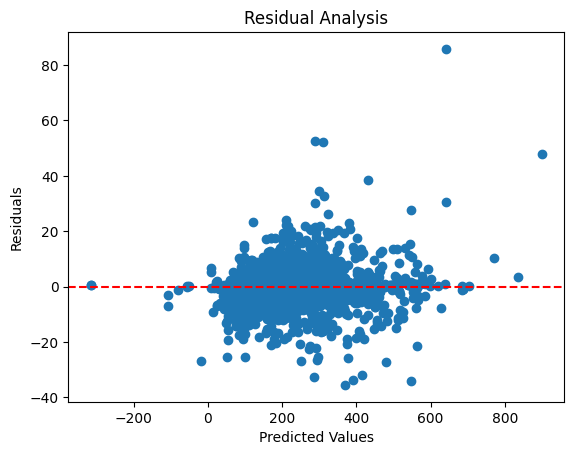

In [23]:
residuals = y1_test - y1_test_pred
plt.scatter(y1_test_pred, residuals)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel("Predicted Values")
plt.ylabel("Residuals")
plt.title("Residual Analysis")
plt.show()

Feature Importance:

Identify the most influential features from Gradient Boosting and Random Forest models using feature_importances_.

1. Feature Importance Analysis
Feature importance analysis will help understand which features are most influential in predicting delivery time. This is especially useful when using tree-based models like Random Forest and Gradient Boosting.

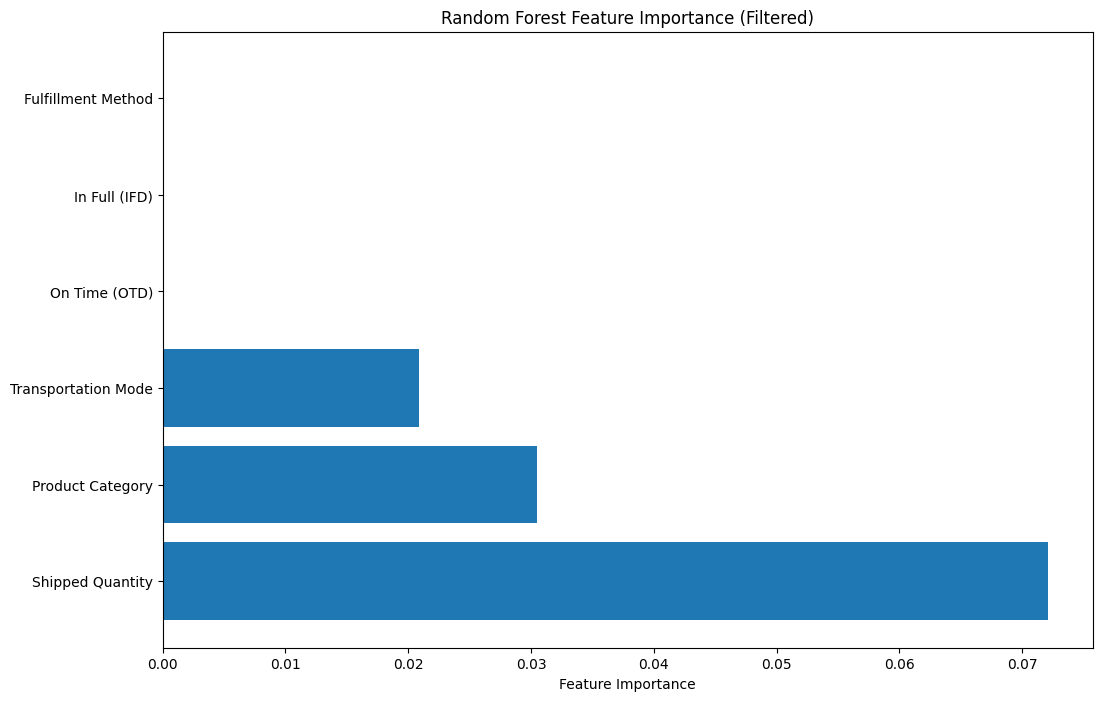

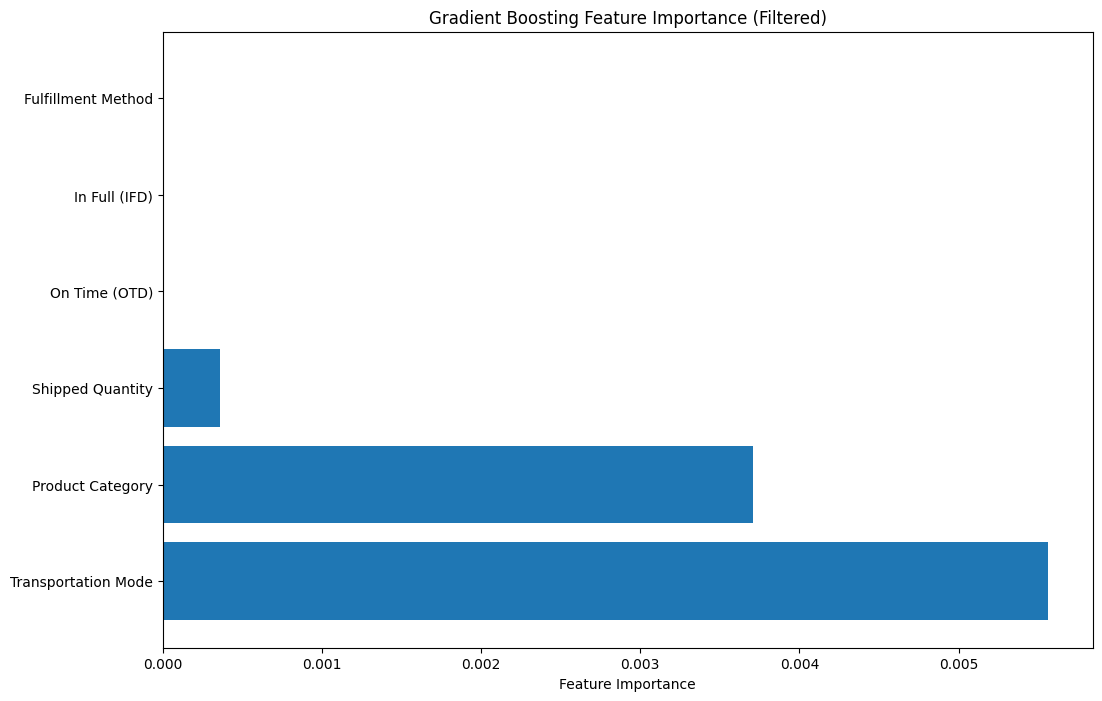

In [ ]:
# List of columns to include in the graph
columns_to_include = [
    "Fulfillment Method", "Transportation Mode", "Product Category",
    "Shipped Quantity", 
    "In Full (IFD)", "On Time (OTD)", "OTIF Status"
]

for model_name, model in tuned_models.items():
    if isinstance(model, RandomForestRegressor) or isinstance(model, GradientBoostingRegressor):
        importances = model.feature_importances_
        feature_names = X.columns
        filtered_indices = [i for i, col in enumerate(feature_names) if col in columns_to_include]
        filtered_importances = importances[filtered_indices]
        filtered_feature_names = [feature_names[i] for i in filtered_indices]
        sorted_indices = np.argsort(filtered_importances)[::-1]
        sorted_importances = filtered_importances[sorted_indices]
        sorted_feature_names = [filtered_feature_names[i] for i in sorted_indices]
        plt.figure(figsize=(12, 8))
        plt.title(f"{model_name} Feature Importance (Filtered)")
        plt.barh(range(len(sorted_importances)), sorted_importances, align="center")
        plt.yticks(range(len(sorted_importances)), sorted_feature_names)
        plt.xlabel("Feature Importance")
        plt.show()
